In [3]:
import pymc as pm
import numpy as np
import pandas as pd
import os
import requests
import io
from datetime import datetime, timedelta
import multiprocessing
import arviz as az
import logging
import matplotlib.pyplot as plt

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
# get data
API_KEY = os.getenv("API_KEY")
url = 'https://data-service.beatthebookie.blog/data'
headers = {"x-api-key": API_KEY}

# Function to fetch data for a specific division and season
def fetch_data(division, season):
    params = {
        'division': division,
        'season': season
    }
    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        return pd.read_json(io.StringIO(response.content.decode('utf-8')))
    else:
        print(f"Error fetching {division} {season}: {response.status_code}")
        print(response.content.decode('utf-8'))
        return pd.DataFrame()

# Fetch data for all combinations
seasons = ['2024_2025', '2023_2024']
divisions = ['Premier League', 'Championship']
dataframes = []

for division in divisions:
    for season in seasons:
        df = fetch_data(division, season)
        if not df.empty:
            dataframes.append(df)

# Combine all dataframes
if dataframes:
    df = pd.concat(dataframes, ignore_index=True)
    
    # Convert match_date to datetime
    df['match_date'] = pd.to_datetime(df['match_date'])

df

,division_id,division,season_id,season,match_date,match_teams,home_team_id,home_team,away_team_id,away_team,...,away_xgoals,home_deep,away_deep,home_ppda,away_ppda,bet365_home_odds,bet365_draw_odds,bet365_away_odds,bet365_u25_odds,bet365_o25_odds
0,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-16,Man United - Fulham,f2b82cdbdadf9d3ec47c3a6be66dcfad,Man United,8cd5e94668b139c1f42a89a1e130f3cf,Fulham,...,0.418711,7.0,3.0,7.379310,10.833333,1.60,4.20,5.25,2.50,1.53
1,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-17,Everton - Brighton,6414a61d98ab23b6d757e888ab17a66a,Everton,0d84883ca72c88cb53c8a38262efdcbc,Brighton,...,1.790830,4.0,5.0,18.333333,7.916667,2.63,3.30,2.63,2.00,1.80
2,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-17,Ipswich - Liverpool,e4f63bf6d6d2cd121e6c8e59bef68209,Ipswich,afce84ff226407a47c9782a742ba02f7,Liverpool,...,3.929060,2.0,13.0,18.777778,8.739130,8.50,5.50,1.33,3.00,1.40
3,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-17,Nott'm Forest - Bournemouth,9a8e1e9fad8766fc3d69a0c26d98b928,Nott'm Forest,b436d55f36cfbe8a085c8b75fb7fe98a,Bournemouth,...,1.909150,10.0,4.0,8.653846,9.954545,2.45,3.50,2.80,2.10,1.73
4,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-17,Newcastle - Southampton,78e9266876e7649e0a12e3840f5be006,Newcastle,5a884401673693b0bdf379fefb7ec2b2,Southampton,...,1.954830,4.0,13.0,16.250000,3.789474,1.36,5.25,8.00,3.00,1.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1618,c4781225ef2d5018f7a9df4b6cb1c1fe,Championship,18b28eb3ae0ef75bc47858e438602442,20232024,2024-05-04,Sunderland - Sheffield Weds,1820e986a8a213df782c5cf5ad0b65e1,Sunderland,ec5c8ee83966ae3a295abeee6ab46871,Sheffield Weds,...,1.300000,NaN,NaN,NaN,NaN,2.70,3.40,2.55,1.80,2.00
1619,c4781225ef2d5018f7a9df4b6cb1c1fe,Championship,18b28eb3ae0ef75bc47858e438602442,20232024,2024-05-04,Rotherham - Cardiff,095ea4179483dfdd7fd4ee61a25954f4,Rotherham,288a6430a6f57a76e823d74e0dd750d2,Cardiff,...,1.300000,NaN,NaN,NaN,NaN,3.40,3.40,2.20,1.73,2.10
1620,c4781225ef2d5018f7a9df4b6cb1c1fe,Championship,18b28eb3ae0ef75bc47858e438602442,20232024,2024-05-04,Leicester - Blackburn,a06360acafe964d244e424cbd50862e8,Leicester,8178de69a5e17f7bbe3a74331977feb1,Blackburn,...,1.700000,NaN,NaN,NaN,NaN,1.70,3.75,5.25,2.50,1.53
1621,c4781225ef2d5018f7a9df4b6cb1c1fe,Championship,18b28eb3ae0ef75bc47858e438602442,20232024,2024-05-04,Plymouth Argyle - Hull,a0111c6b8f3812f2e36ababf2c032d8c,Plymouth Argyle,63b0fc998685327831f96bbe7b07b7e2,Hull,...,0.500000,NaN,NaN,NaN,NaN,3.50,3.75,2.00,2.30,1.62


In [ ]:
def build_model(matches_df):
    # Get unique teams
    teams = sorted(set(matches_df['home_team']).union(set(matches_df['away_team'])))
    n_teams = len(teams)
    team_indices = {team: idx for idx, team in enumerate(teams)}
    
    # Create indices for home and away teams
    home_idx = np.array([team_indices[team] for team in matches_df['home_team']])
    away_idx = np.array([team_indices[team] for team in matches_df['away_team']])
    
    # Observed goals
    home_goals = matches_df['home_goals'].values
    away_goals = matches_df['away_goals'].values

    # Calculate days since most recent match
    dates = pd.to_datetime(matches_df['match_date'])
    max_date = dates.max()
    days_since = (max_date - dates).dt.days.values

    
    with pm.Model() as model:
        decay_rate = 0.001
        #decay_rate = pm.HalfNormal('decay_rate', sigma=0.002)
        
        # Calculate weights directly
        time_weights = pm.math.exp(-decay_rate * days_since)
        
        # The rest of your model...
        home_adv = pm.Normal('home_adv', mu=0.25, sigma=0.2)
        attack = pm.ZeroSumNormal('attack', sigma=0.5, shape=n_teams)
        defense = pm.ZeroSumNormal('defense', sigma=0.5, shape=n_teams)

        home_goals_lambda = pm.math.exp(home_adv + attack[home_idx] + defense[away_idx])
        away_goals_lambda = pm.math.exp(attack[away_idx] + defense[home_idx])
        
        # Calculate log probabilities
        home_rv = pm.Poisson.dist(mu=home_goals_lambda)
        away_rv = pm.Poisson.dist(mu=away_goals_lambda)
        
        home_logp = pm.logp(home_rv, home_goals)
        away_logp = pm.logp(away_rv, away_goals)
        
        # Create potentials with weighted sum
        pm.Potential('weighted_home_likelihood', (home_logp * time_weights).sum())
        pm.Potential('weighted_away_likelihood', (away_logp * time_weights).sum())

    return model

def sample_model(model, draws=1000, tune=1000, chains=4, cores=None):
    with model:
        trace = pm.sample(draws=draws, tune=tune, chains=chains, cores=cores, return_inferencedata=True)
    return trace

def plot_team_strengths(trace, teams):
    """Plot the attack and defense strengths of teams"""
    attack = az.summary(trace.posterior.attack, kind="stats")["mean"].values
    defense = az.summary(trace.posterior.defense, kind="stats")["mean"].values
    
    # Create a dataframe for plotting
    team_strengths = pd.DataFrame({
        'Team': teams,
        'Attack': attack,
        'Defense': defense
    })
    
    # Sort by attack strength (higher is better)
    team_strengths_attack = team_strengths.sort_values('Attack', ascending=False)
    
    # Sort by defense strength (lower is better)
    team_strengths_defense = team_strengths.sort_values('Defense', ascending=True)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))
    
    # Attack plot
    team_strengths_attack.plot.bar(x='Team', y='Attack', ax=ax1, color='skyblue')
    ax1.set_title('Team Attack Strengths')
    ax1.set_ylabel('Attack Parameter (higher is better)')
    ax1.tick_params(axis='x', labelrotation=90)
    
    # Defense plot
    team_strengths_defense.plot.bar(x='Team', y='Defense', ax=ax2, color='salmon')
    ax2.set_title('Team Defense Strengths')
    ax2.set_ylabel('Defense Parameter (lower is better)')
    ax2.tick_params(axis='x', labelrotation=90)
    
    plt.tight_layout()
    return fig

def check_convergence(trace):
    # 1. Summary including R-hat and ESS
    summary = az.summary(trace)
    print("R-hat values > 1.05:")
    print(summary[summary['r_hat'] > 1.05])
    
    # 2. Trace plots
    ax = az.plot_trace(trace, var_names=['home_adv', 'attack', 'defense'], 
                      compact=True)
    fig = ax[0, 0].figure
    fig.tight_layout()
    
    # 3. Energy plot
    energy_fig = az.plot_energy(trace)
    
    # 4. Rank plots (checks exchangeability of chains)
    rank_fig = az.plot_rank(trace, var_names=['home_adv'])
    
    # 5. Detailed diagnostics
    diagnostics = {
        'divergences': trace.sample_stats.diverging.sum().item(),
        'min_ess': summary['ess_bulk'].min(),
        'max_rhat': summary['r_hat'].max()
    }
    
    return {
        'summary': summary,
        'trace_fig': fig,
        'energy_fig': energy_fig,
        'rank_fig': rank_fig,
        'diagnostics': diagnostics
    }


def posterior_predictive_check(model, trace, matches_df):
    """Perform posterior predictive checks"""
    
    with model:
        # Generate predictions using parameters from the posterior
        posterior_pred = pm.sample_posterior_predictive(trace)
    
    # Compare predictions with actual data
    home_goals_pred = posterior_pred.posterior_predictive.home_goals.values
    away_goals_pred = posterior_pred.posterior_predictive.away_goals.values
    
    # Flatten for easier plotting
    home_goals_pred_flat = home_goals_pred.reshape(-1, home_goals_pred.shape[-1])
    away_goals_pred_flat = away_goals_pred.reshape(-1, away_goals_pred.shape[-1])
    
    # Calculate statistics from predictions
    home_goals_mean = home_goals_pred_flat.mean(axis=0)
    away_goals_mean = away_goals_pred_flat.mean(axis=0)
    
    # Compare with observed data
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Home goals
    axes[0].scatter(matches_df['home_goals'], home_goals_mean, alpha=0.5)
    axes[0].plot([0, max(matches_df['home_goals'])], [0, max(matches_df['home_goals'])], 'r--')
    axes[0].set_xlabel('Observed Home Goals')
    axes[0].set_ylabel('Predicted Home Goals')
    axes[0].set_title('Home Goals: Observed vs Predicted')
    
    # Away goals
    axes[1].scatter(matches_df['away_goals'], away_goals_mean, alpha=0.5)
    axes[1].plot([0, max(matches_df['away_goals'])], [0, max(matches_df['away_goals'])], 'r--')
    axes[1].set_xlabel('Observed Away Goals')
    axes[1].set_ylabel('Predicted Away Goals')
    axes[1].set_title('Away Goals: Observed vs Predicted')
    
    plt.tight_layout()
    return fig

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [decay_rate, home_adv, attack, defense]


Output()

Sampling 2 chains for 200 tune and 200 draw iterations (400 + 400 draws total) took 335 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


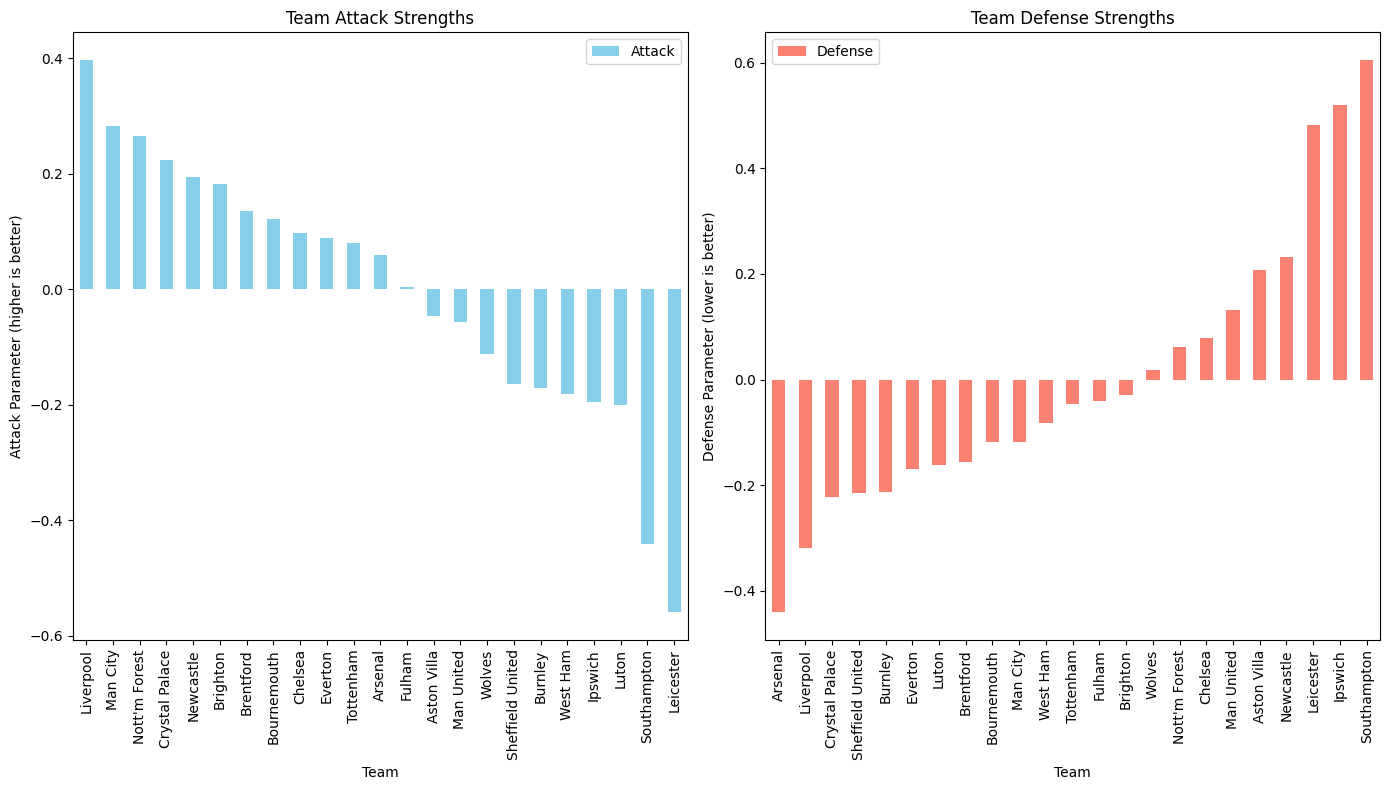

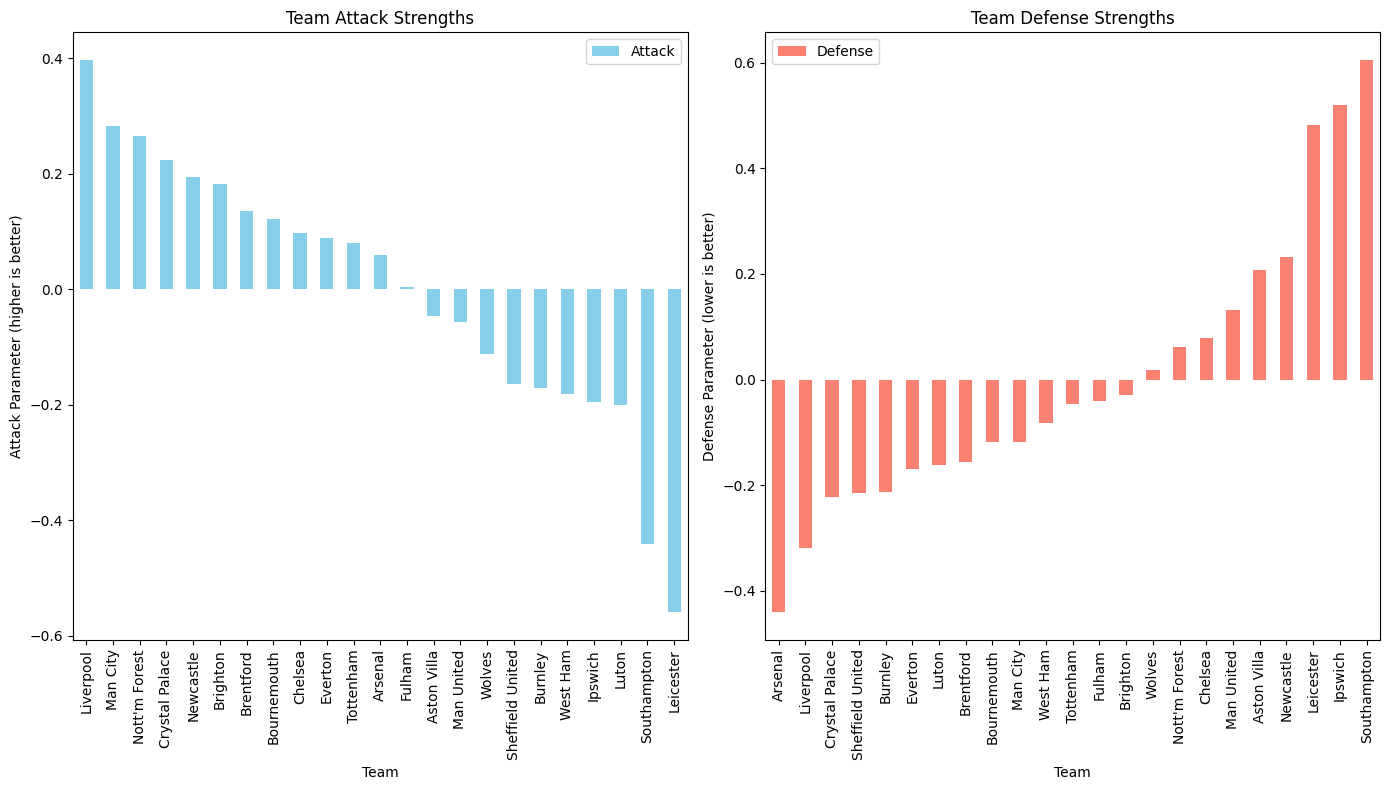

In [16]:
matches_df = df[df['match_date'] > datetime.now() - timedelta(days=365)]
matches_df = matches_df[matches_df['division'] == 'Premier League']


matches_df = matches_df[["match_date", "home_team", "away_team", "home_goals", "away_goals"]]

model = build_model(matches_df)
trace = sample_model(model, draws=200, tune=200, chains=2, cores=multiprocessing.cpu_count())

teams = sorted(set(matches_df['home_team']).union(set(matches_df['away_team'])))

plot_team_strengths(trace, teams)

In [17]:
matches_df.sort_values(by="match_date").head()

,match_date,home_team,away_team,home_goals,away_goals
548,2024-03-11,Chelsea,Newcastle,3,2
549,2024-03-13,Bournemouth,Luton,4,3
550,2024-03-16,Luton,Nott'm Forest,1,1
551,2024-03-16,Fulham,Tottenham,3,0
552,2024-03-16,Burnley,Brentford,2,1


R-hat values > 1.05:
Empty DataFrame
Columns: [mean, sd, hdi_3%, hdi_97%, mcse_mean, mcse_sd, ess_bulk, ess_tail, r_hat]
Index: []


{'summary':               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
 home_adv     0.238  0.105   0.038    0.427      0.005    0.004     456.0   
 decay_rate   0.026  0.001   0.024    0.029      0.000    0.000     587.0   
 attack[0]    0.059  0.293  -0.520    0.620      0.016    0.016     347.0   
 attack[1]   -0.047  0.276  -0.604    0.406      0.012    0.011     557.0   
 attack[2]    0.121  0.296  -0.456    0.593      0.011    0.013     683.0   
 attack[3]    0.135  0.283  -0.306    0.718      0.012    0.012     556.0   
 attack[4]    0.182  0.265  -0.349    0.650      0.013    0.011     422.0   
 attack[5]   -0.171  0.483  -1.096    0.664      0.015    0.029     930.0   
 attack[6]    0.098  0.278  -0.428    0.589      0.011    0.011     597.0   
 attack[7]    0.223  0.264  -0.267    0.678      0.010    0.010     703.0   
 attack[8]    0.088  0.310  -0.422    0.742      0.013    0.015     587.0   
 attack[9]    0.004  0.284  -0.438    0.539      0.012    0.012  

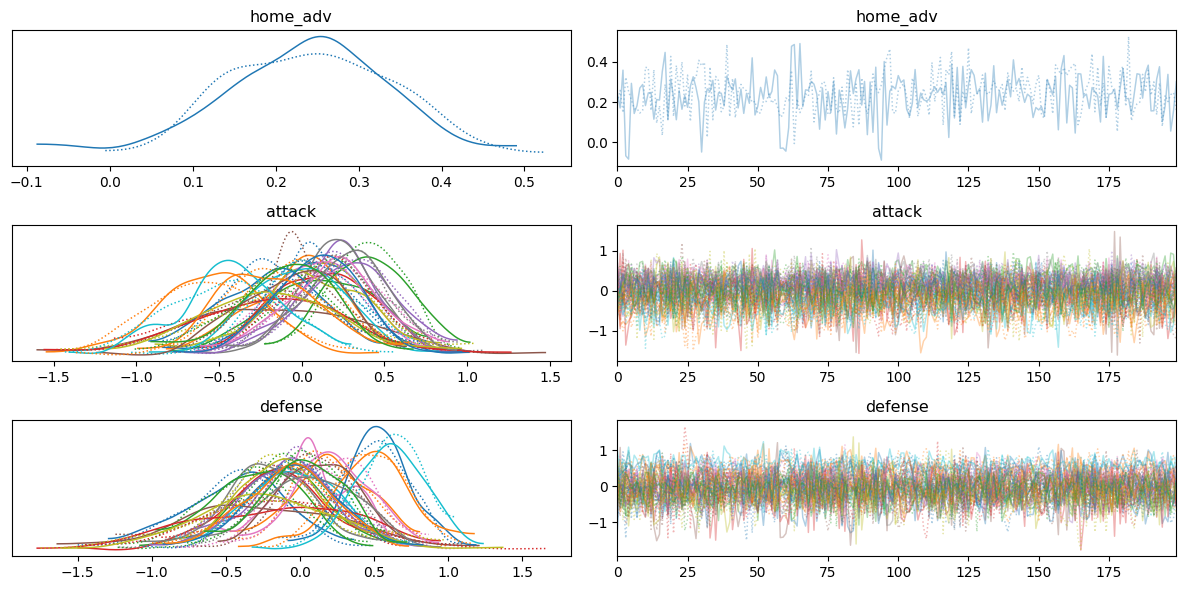

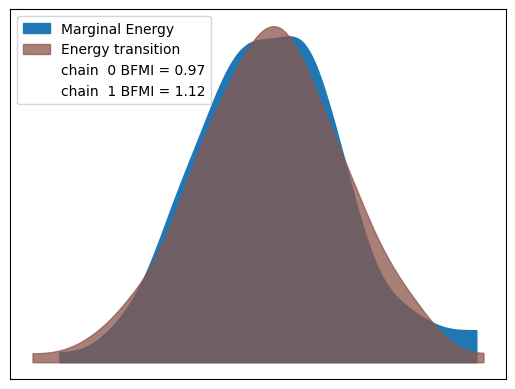

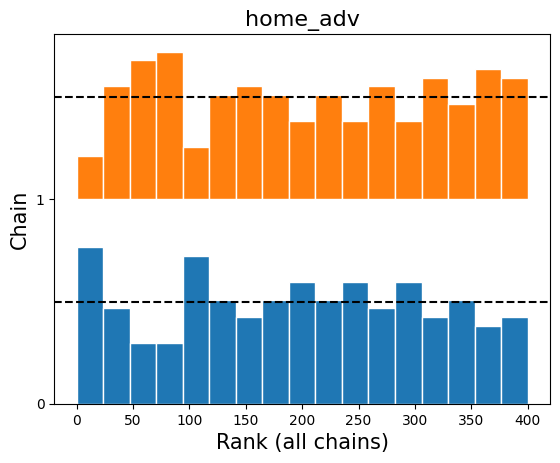

In [18]:
check_convergence(trace)

In [19]:
posterior_predictive_check(model, trace, matches_df)

C:\Users\Owner\AppData\Local\Temp\ipykernel_2160\2801677855.py:129: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  posterior_pred = pm.sample_posterior_predictive(trace)


AttributeError: 'InferenceData' object has no attribute 'posterior_predictive'